#Predictive Analytics - Prediksi Harga Saham PT Telekomunikasi Indonesia Tbk (TLKM.JK)

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## Data Loading
Dataset yang digunakan bersumber dari kaggle: https://www.kaggle.com/datasets/irfansaputranst/dataset-saham-tlkm-jk

Dataset ini terdiri dari 7 kolom diantaranya:
- **Date**    : Tanggal pencatatan data dalam format DD/MM/YYYY.
- **Adj Close**: Harga penutupan yang telah disesuaikan untuk memberikan nilai lebih akurat, termasuk dividen dan pembagian saham.
- **Close**    : Harga penutupan pada akhir hari perdagangan.
- **High**    : Harga tertinggi yang dicapai saham pada hari perdagangan tersebut.
- **Low**      : Harga terendah yang dicapai saham pada hari perdagangan tersebut.
- **Open**     : Harga pembukaan saham di awal hari perdagangan.
- **Volume**   : Jumlah volume saham yang diperdagangkan pada hari tersebut (dalam format angka bertitik, perlu diubah ke format numerik untuk analisis).

In [2]:
df = pd.read_csv('/content/SAHAM - PT Telekomunikasi Indonesia Tbk (TLKM.JK) - Sheet1.csv')
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,07/11/2019,3216.63,4070.0,4150.0,3990.0,4150.0,125.291.200
1,08/11/2019,3248.24,4110.0,4120.0,3990.0,4010.0,70.404.800
2,11/11/2019,3240.34,4100.0,4120.0,4040.0,4040.0,57.079.800
3,12/11/2019,3303.57,4180.0,4190.0,4050.0,4050.0,88.251.100
4,13/11/2019,3279.86,4150.0,4170.0,4100.0,4130.0,91.925.700


##Data Understanding

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1212 entries, 0 to 1211
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1212 non-null   object 
 1   Adj Close  1212 non-null   float64
 2   Close      1212 non-null   float64
 3   High       1212 non-null   float64
 4   Low        1212 non-null   float64
 5   Open       1212 non-null   float64
 6   Volume     1212 non-null   object 
dtypes: float64(5), object(2)
memory usage: 66.4+ KB


Note: Type data pada kolom date dan volume masih belum sesuai, maka perlu dilakukan mengubah type data,

date = objet > datetime dan

volume = object > float

In [4]:
#Ubah kolom 'Date' ke format datetime (DD/MM/YYYY)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

# Ubah kolom 'Volume' ke float
# Hilangkan titik pemisah ribuan terlebih dahulu
df['Volume'] = df['Volume'].str.replace('.', '', regex=False).astype(float)

# Cek hasil
print(df.dtypes)
print(df.head())

Adj Close    float64
Close        float64
High         float64
Low          float64
Open         float64
Volume       float64
dtype: object
            Adj Close   Close    High     Low    Open       Volume
Date                                                              
2019-11-07    3216.63  4070.0  4150.0  3990.0  4150.0  125291200.0
2019-11-08    3248.24  4110.0  4120.0  3990.0  4010.0   70404800.0
2019-11-11    3240.34  4100.0  4120.0  4040.0  4040.0   57079800.0
2019-11-12    3303.57  4180.0  4190.0  4050.0  4050.0   88251100.0
2019-11-13    3279.86  4150.0  4170.0  4100.0  4130.0   91925700.0


In [5]:
#Statistik deskriptif setelah mengubah tipe data
df.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1.212000e+03
mean,3232.919909,3647.978548,3690.998350,3607.483498,3650.981848,1.161022e+08
std,506.366462,510.865708,508.614228,508.024318,508.843617,7.744300e+07
min,2070.660000,2560.000000,2590.000000,2450.000000,2550.000000,0.000000e+00
25%,2835.450000,3190.000000,3250.000000,3150.000000,3200.000000,6.933892e+07
50%,3228.050000,3720.000000,3765.000000,3690.000000,3720.000000,9.611110e+07
75%,3666.010000,4030.000000,4060.000000,3990.000000,4030.000000,1.395841e+08
max,4295.700000,4770.000000,4850.000000,4720.000000,4850.000000,1.155861e+09


##Menangani Missing Value dan Outliers

In [6]:
data = df.isnull().sum()
print("Jumlah missing value pada setiap kolom:")
print(data)

Jumlah missing value pada setiap kolom:
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


In [7]:
data = df.duplicated().sum()
print("Jumlah data duplikat:")
print(data)

Jumlah data duplikat:
0


In [8]:
# Hanya ambil kolom numerik
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

outlier_counts = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = outliers.shape[0]

# Tampilkan jumlah outlier tiap kolom
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Jumlah Outlier'])
print(outlier_df)

           Jumlah Outlier
Adj Close               0
Close                   0
High                    0
Low                     0
Open                    0
Volume                 64


Note: Terdapat outlier pada kolom volume.

metode IQR digunakan untuk mengatasi outlier

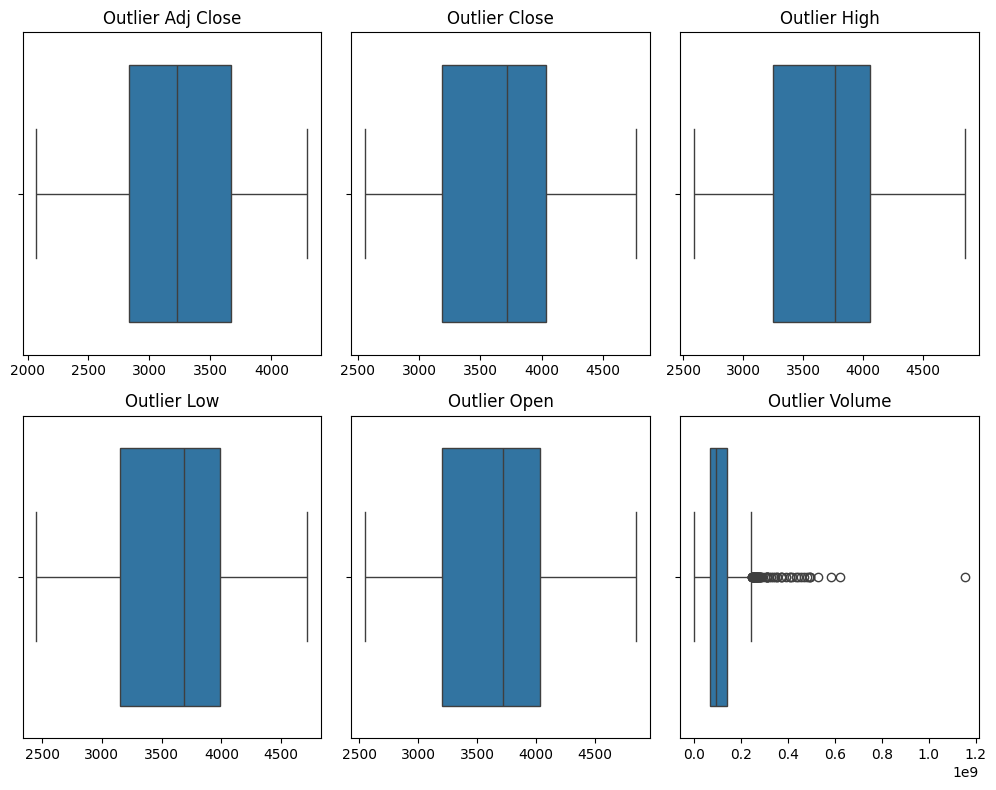

In [9]:
# Membuat plot boxplot untuk setiap kolom numerik
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Outlier {col}')
    axes[i].set_xlabel('') # Kosongkan label x untuk kebersihan

# Menyembunyikan subplot yang tidak digunakan jika jumlah kolom ganjil
if len(num_cols) < len(axes):
    for j in range(len(num_cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Axes: xlabel='Volume'>

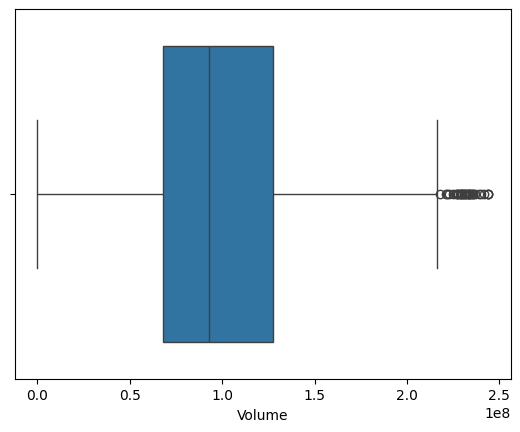

In [10]:
#Menghitung Q1, Q3, dan IQR hanya untuk kolom Volume
Q1 = df['Volume'].quantile(0.25)
Q3 = df['Volume'].quantile(0.75)
IQR = Q3 - Q1

filter_outliers = ~((df['Volume'] < (Q1 - 1.5 * IQR)) |
                    (df['Volume'] > (Q3 + 1.5 * IQR)))

df = df[filter_outliers]
# Cek ukuran dataset setelah outlier dihapus
df.shape

sns.boxplot(x=df['Volume'])

In [11]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = outliers.shape[0]

# Tampilkan jumlah outlier tiap kolom
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Jumlah Outlier'])
print(outlier_df)

           Jumlah Outlier
Adj Close               0
Close                   0
High                    0
Low                     0
Open                    0
Volume                 34


### Eksploratory Data Analysis (EDA)

In [12]:
#Memeriksa jumlah nilai unique pada tiap kolom
print("\n=== UNIQUE VALUES PER COLUMN ===")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")
    if df[col].dtype == 'object':
        print(f"  Values: {df[col].unique()}")
    print()



=== UNIQUE VALUES PER COLUMN ===
Adj Close: 479 unique values

Close: 209 unique values

High: 210 unique values

Low: 207 unique values

Open: 203 unique values

Volume: 1148 unique values



## Analisis Korelasi Antar Variabel

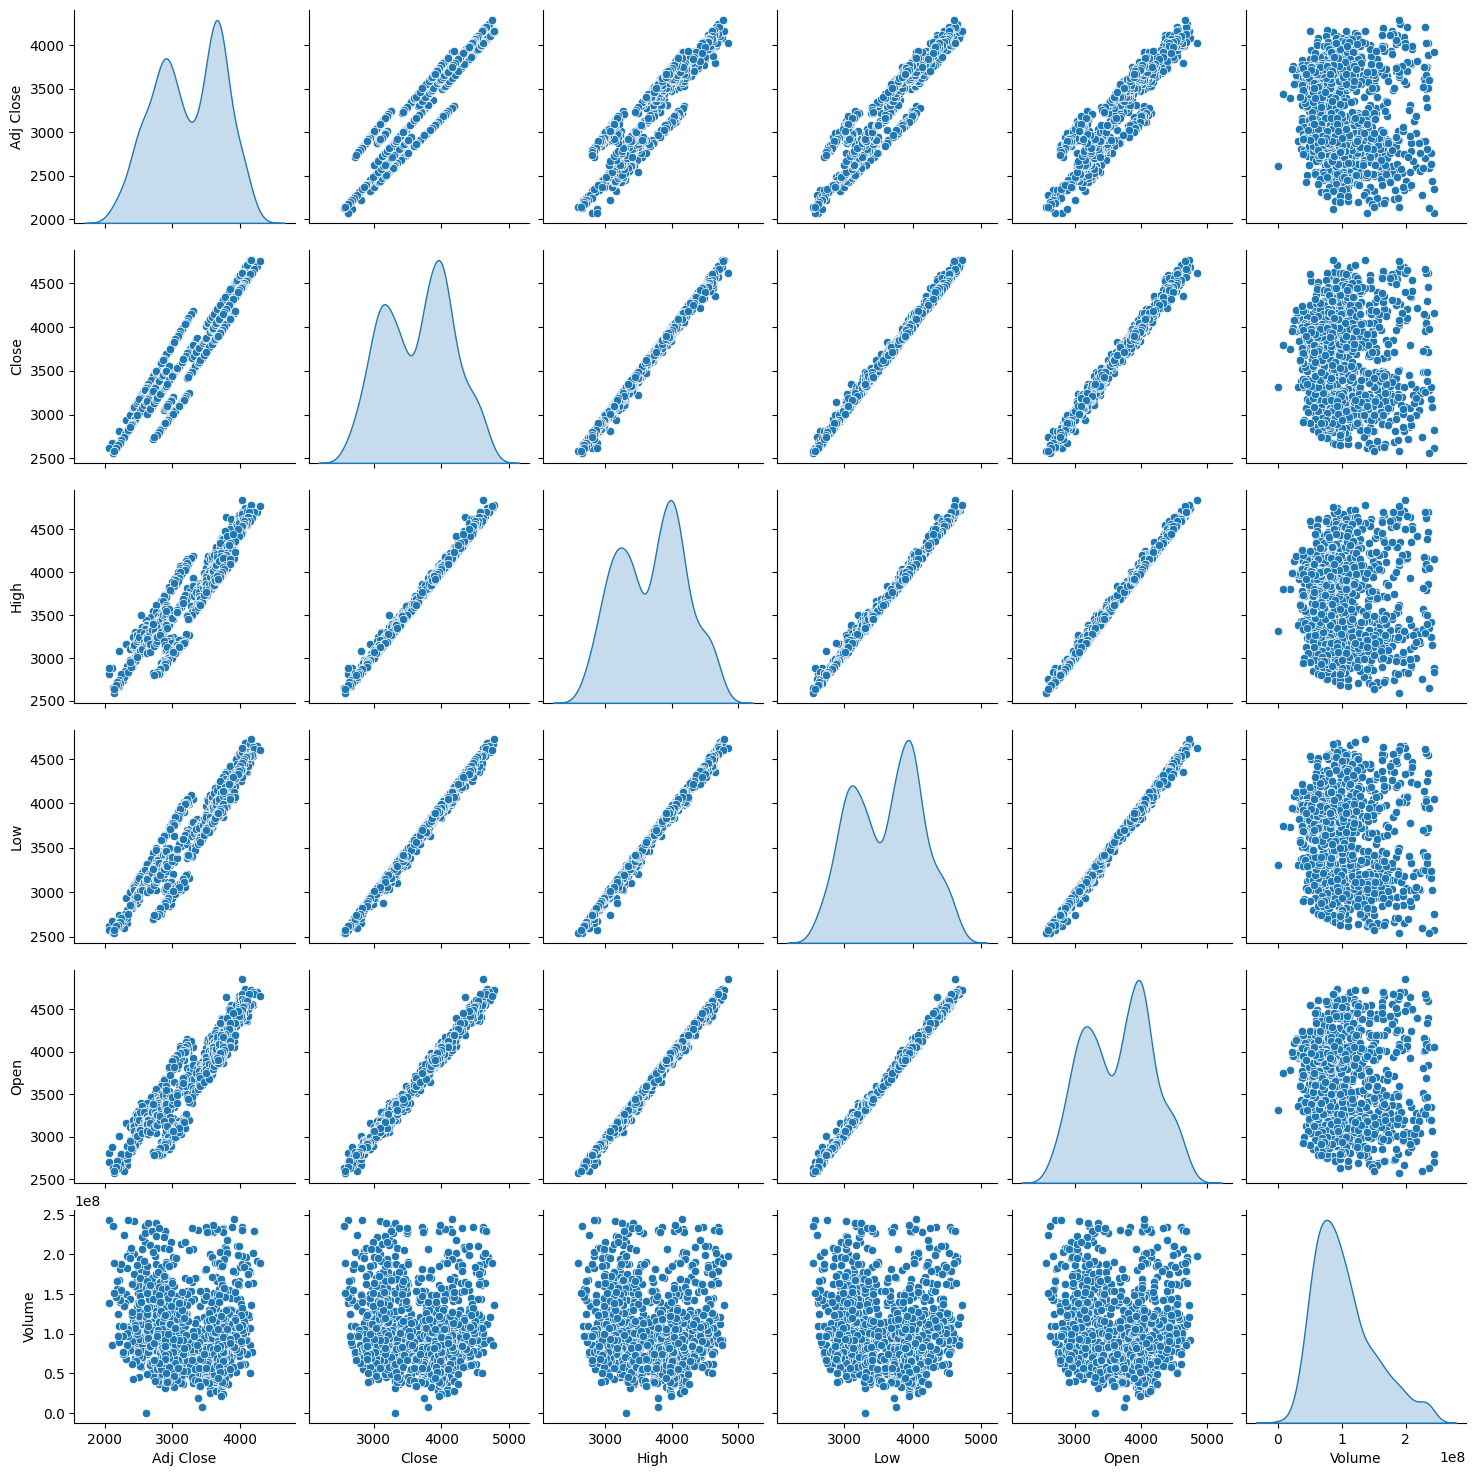

In [13]:
sns.pairplot(df, diag_kind = 'kde')

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

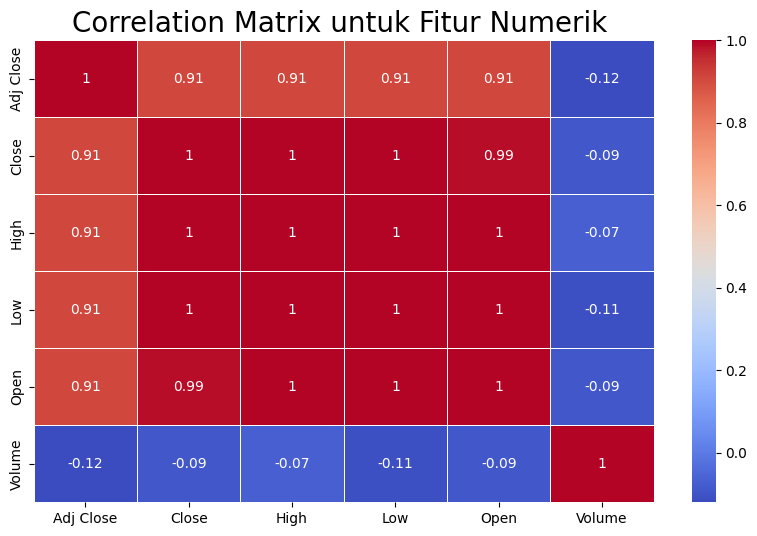

In [14]:
# Heatmap Korelasi
plt.figure(figsize=(10, 6))
correlation_matrix = df.corr().round(2)

# Untuk menge-print nilai di dalam kotak, gunakan parameter anot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Note:

- Korelasi antara Adj Close, Close, Open, High, Low sangat tinggi (0.90 – 1.00). Hal ini menunjukan bahwa harga-harga saham ini berjalan sangat selaras, karena: Harga buka, tutup, tertinggi, dan terendah harian biasanya berbeda tipis. Close dan Adj Close hampir identik, perbedaannya terletak pada penyesuaian dividen/split
- Korelasi volme dengan semua kolom sangat rendah dan negatif (-0.08 s/d -0.13) Hal ini menunjukan bahwa Volume tidak punya hubungan linier kuat dengan harga.



## Visualisasi Data

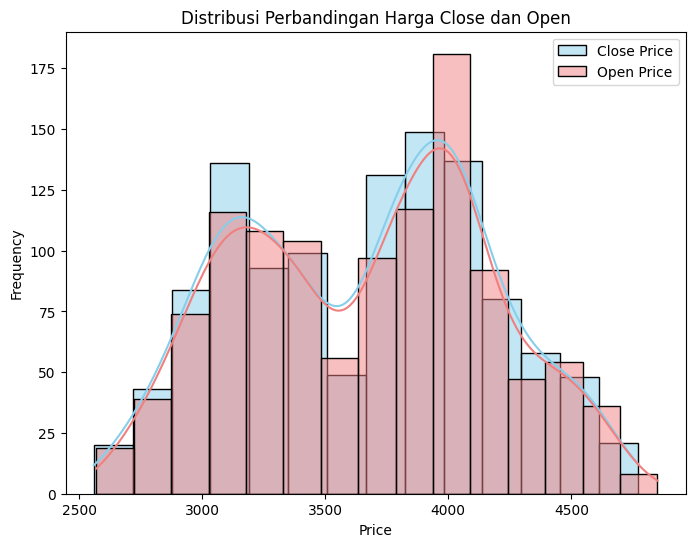

In [15]:
#visualisasi untuk melihat distribusi perbandingan harga pada kolom close dan open

plt.figure(figsize=(8, 6))
sns.histplot(df['Close'], color='skyblue', label='Close Price', kde=True)
sns.histplot(df['Open'], color='lightcoral', label='Open Price', kde=True)
plt.title('Distribusi Perbandingan Harga Close dan Open')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Note:

- Harga penutupan cenderung lebih tinggi dari harga pembukaan.
- Kedua distribusi sangat mirip dan saling tumpang tindih, yang mengindikasikan bahwa secara umum, tidak ada perbedaan signifikan antara harga pembukaan dan penutupan dalam jangka panjang.

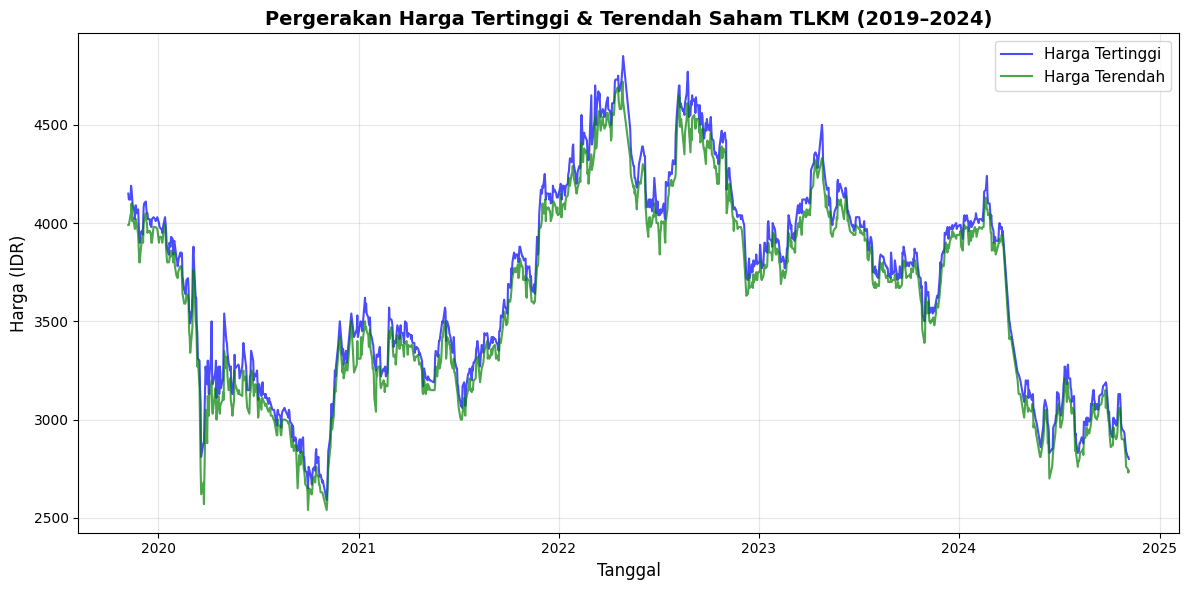

In [16]:
#Melihat trend harga terendah dan harga tertinggi
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['High'], label='Harga Tertinggi', color='blue', alpha=0.7, linewidth=1.5)
plt.plot(df.index, df['Low'], label='Harga Terendah', color='green', alpha=0.7, linewidth=1.5)

plt.title('Pergerakan Harga Tertinggi & Terendah Saham TLKM (2019–2024)', fontsize=14, fontweight='bold')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga (IDR)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Insight**
- Perbedaan antara garis biru (harga tertinggi) dan garis hijau (harga terendah) mencerminkan volatilitas harian, yaitu tingkat fluktuasi harga dalam satu hari. Semakin besar jaraknya, semakin tinggi tingkat volatilitas harian saham.
- Harga saham menunjukkan tren kenaikan yang konsisten dari pertengahan 2021 hingga mencapai puncaknya pada pertengahan 2022.
- Harga tertinggi dan harga terendah cenderung bergerak seiring, yang menunjukkan tidak terdapat anomali ekstrem atau pergerakan harga yang tidak wajar selama periode tersebut.

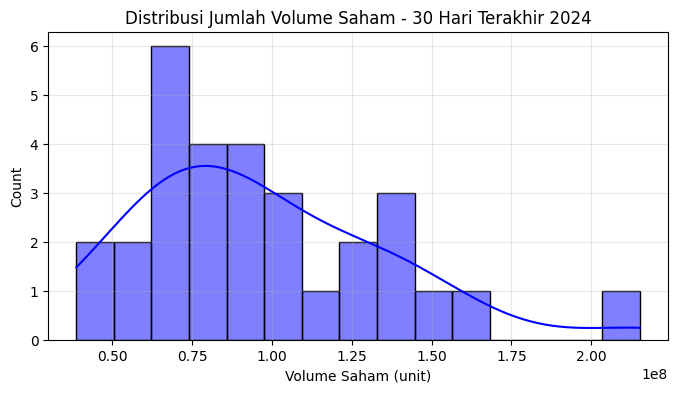

In [17]:
# Pastikan index datetime
df.index = pd.to_datetime(df.index)

# Ambil data tahun 2024 saja
df_2024 = df[df.index.year == 2024]

# Ambil 30 hari terakhir
df_last_30 = df_2024.tail(30)

plt.figure(figsize=(8,4))
sns.histplot(df_last_30['Volume'], kde=True, bins=15, color='blue')
plt.title('Distribusi Jumlah Volume Saham - 30 Hari Terakhir 2024')
plt.xlabel('Volume Saham (unit)')
plt.grid(alpha=0.3)
plt.show()


##Modelling

###Normalisasi dan Splitting Data

In [18]:
# Pisahkan fitur dan target
X = df.drop(columns=['Adj Close'])
y = df['Adj Close'].values.reshape(-1, 1)  # Ubah ke array 2D agar bisa di-scale

#Standardisasi data
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(X)

# Untuk fitur (X) - multi kolom
scaler_X = MinMaxScaler()
scaled_x = scaler_X.fit_transform(X)

# Untuk target (y) - satu kolom
scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(y.reshape(-1, 1))

In [19]:
# Split data menjadi train dan test dengan 80% untuk data train dan 20% data test
train_size = int(len(scaled_x) * 0.8)
train, test = scaled_x[0:train_size,:], scaled_x[train_size:len(scaled_x),:]

print(f"Train Size: {len(train)}")
print(f"Test Size: {len(test)}")

Train Size: 918
Test Size: 230


###Modelling dengan LSTM

In [20]:
# Fungsi untuk membuat dataset berbasis window time series
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # 60 time steps sebagai feature
        y.append(data[i, 0])              # Nilai berikutnya sebagai target
    return np.array(X), np.array(y)

# Membuat training set
time_step = 60
X_train, y_train = create_dataset(train, time_step)

# Membuat test set
X_test, y_test = create_dataset(test, time_step)

# Reshape input untuk LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (858, 60, 1)
y_train shape: (858,)
X_test shape: (170, 60, 1)
y_test shape: (170,)


In [21]:
#Membuat model dengan LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [23]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.1588 - mean_absolute_error: 0.3254 - val_loss: 0.0174 - val_mean_absolute_error: 0.1017
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0122 - mean_absolute_error: 0.0866 - val_loss: 0.0079 - val_mean_absolute_error: 0.0630
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0097 - mean_absolute_error: 0.0759 - val_loss: 0.0072 - val_mean_absolute_error: 0.0619
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0087 - mean_absolute_error: 0.0714 - val_loss: 0.0059 - val_mean_absolute_error: 0.0593
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0072 - mean_absolute_error: 0.0650 - val_loss: 0.0054 - val_mean_absolute_error: 0.0603
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0080 - mean_absolute_error: 0.0671 - val_loss: 0.0048 - val_mean_absolute_error: 0.0565
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0075 - mean_absolute_error: 0.0667 - v

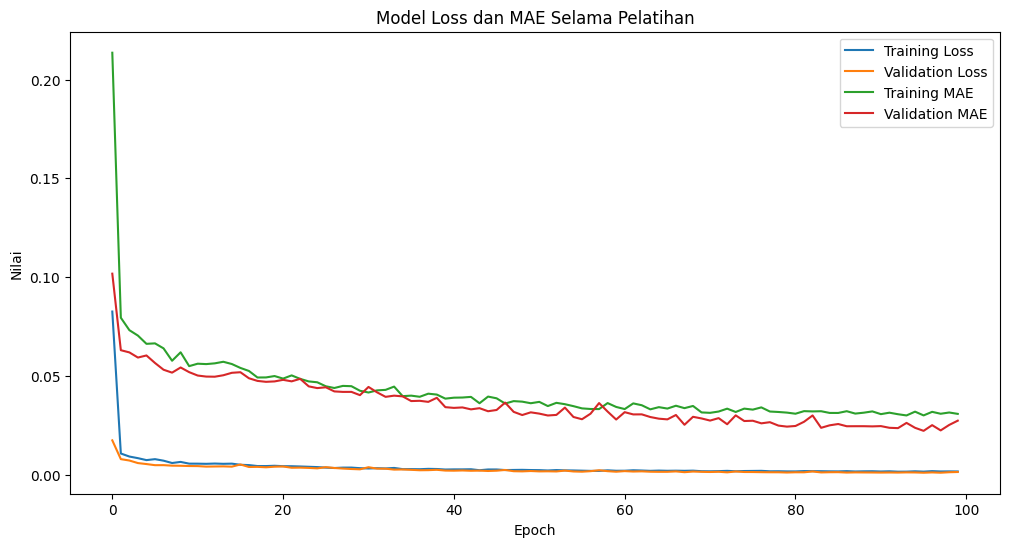

In [24]:
#Visualisasi hasil training dan validasi
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Loss dan MAE Selama Pelatihan')
plt.ylabel('Nilai')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Note:

Dari grafik dapat disimpulkan bahwa tidak ada indikasi kuat terjadinya overfitting. hal tersebut terlihat dari gap antara training loss dan validation loss yang tidak terlalu besar.

### Prediksi & Evaluasi

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prediksi & inverse transform
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))


# Evaluasi
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, predictions)

print(f"\nTest MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Test MSE: 4971.9093
Test RMSE: 70.5118
Test MAE: 49.3889
Test MAPE: 1.86%
R² Score: 0.9731


Note: Score R² mencapai 97% dan MAPE sangat rendah menunjukan bahwa model LSTM sudah baik

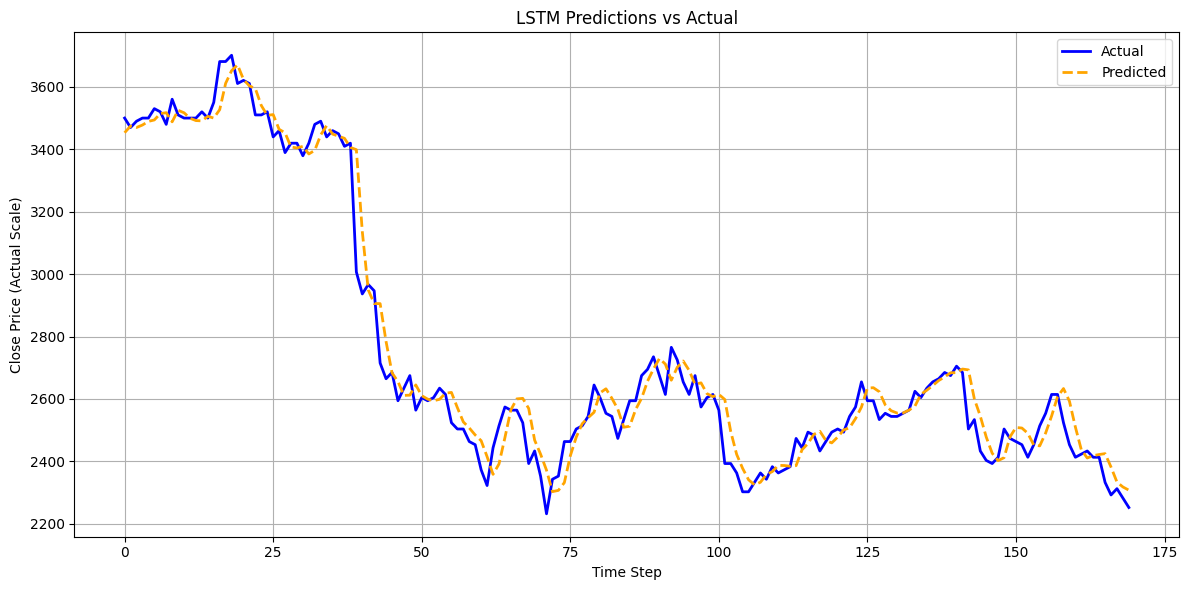

In [27]:
# Visualisasi hasil prediksi
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual', color='blue', linewidth=2)
plt.plot(predictions, label='Predicted', color='orange', linewidth=2, linestyle='--')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Close Price (Actual Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Kesimpulan
Hasil Evaluasi Model:

Model yang dibangun menunjukkan performa prediksi yang sangat baik, dengan akurasi tinggi dan nilai prediksi yang sangat dekat dengan nilai aktual. Hal ini ditunjukkan oleh hasil evaluasi berikut:

- Mean Squared Error (MSE): 4971.9093
- Root Mean Squared Error (RMSE): 70.5118
- Mean Absolute Error (MAE): 49.3889
- Mean Absolute Percentage Error (MAPE): 1.86%
- R² Score: 0.9731

Nilai R² sebesar 0.9731 mengindikasikan bahwa model mampu menjelaskan sekitar 97% variasi pada data target. Sementara itu, nilai MAPE yang rendah (1.86%) menunjukkan kesalahan prediksi relatif yang sangat kecil terhadap nilai aktual.

Dengan kombinasi error yang rendah dan R² yang tinggi, serta perbandingan performa training dan testing yang konsisten, dapat disimpulkan bahwa model tidak mengalami overfitting dan memiliki generalisasi yang baik terhadap data baru.


